1. Import Required Libraries

In [1]:
import os
import random

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.transforms import InterpolationMode

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

  
from datetime import datetime
# Save the trained model with timestamp

#from models import Model
#from datasets import get_data_loaders
#from train import train
#from test import evaluate, load_model

# Check versions
print(torch.__version__)
print(torchvision.__version__)

KeyboardInterrupt: 

2. Set the Hyperparameters

In [37]:
# Paths to real and fake image directories
train_real_path = r"D:\Projects\SP CUP Dataset\train\real" # r is because of the backslash causing \p 
train_fake_path = r"D:\Projects\SP CUP Dataset\train\fake" # to be interpreted as a special character

test_real_path = r"D:\Projects\SP CUP Dataset\valid\real"
test_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake"

#Small Dataset
#train_real_path = r"D:\Projects\SP CUP Dataset\valid\real" # r is because of the backslash causing \p 
#train_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake" # to be interpreted as a special character

#test_real_path = r"D:\Projects\SP CUP Dataset\Small train\real"
#test_fake_path = r"D:\Projects\SP CUP Dataset\Small train\fake"
#r"D:\Projects\SP CUP Dataset\Small train\real"
#r"D:\Projects\SP CUP Dataset\Small train\fake"

#Define the maximum number of samples per class
TRAIN_MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit
TEST_MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

BATCH_SIZE = 16 # Batch size for training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



✔ 1 for real and 0 for fake since classes = ['fake', 'real']
fileID <TAB> score where fileID is the id of the test file, and score is a numerical value -- a higher value for real images and lower value for fake images.(from documentation)

✔ The train_dataloader is created with shuffle=True to shuffle the training data at the beginning of each epoch. (not implemented )

✔ The test_dataloader is created with shuffle=False to keep the order of the test data consistent.

✔Read efficientnet documentation and act accordingly

Way to save the model using checkpoints.

Way to get std and mean of the provided dataset

Apply regularization (Model markdown)

3. Set dataset folders for training

In [38]:
# Get the image filenames
train_real_count = len(os.listdir(train_real_path))
train_fake_count = len(os.listdir(train_fake_path))

test_real_count = len(os.listdir(test_real_path))
test_fake_count = len(os.listdir(test_fake_path))

print(f"Train Real images: {train_real_count}, Train Fake images: {train_fake_count}")
print(f"Test Real images: {test_real_count}, Test Fake images: {test_fake_count}")

Train Real images: 42690, Train Fake images: 219470
Test Real images: 1548, Test Fake images: 1524


4.1 Preparing Training Data

In [39]:
random.seed(42)# Set the seed for reproducibility

# Get the image filenames
train_real_images = os.listdir(train_real_path)
train_fake_images = os.listdir(train_fake_path)

# Apply the limit
train_real_images = train_real_images[:min(TRAIN_MAX_SAMPLES_PER_CLASS, len(train_real_images))]
train_fake_images = train_fake_images[:min(TRAIN_MAX_SAMPLES_PER_CLASS, len(train_fake_images))]

# Combine and label the dataset
train_balanced_dataset = [(os.path.join(train_real_path, img), 1) for img in train_real_images] + \
                   [(os.path.join(train_fake_path, img), 0) for img in train_fake_images]

# Shuffle the dataset
random.shuffle(train_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(train_balanced_dataset)} (Real: {len(train_real_images)}, Fake: {len(train_fake_images)})")


Total dataset size: 80000 (Real: 40000, Fake: 40000)


4.2 Preparing Testing Data

In [40]:
random.seed(42)# Set the seed for reproducibility

# Get the image filenames
test_real_images = os.listdir(test_real_path)
test_fake_images = os.listdir(test_fake_path)

# Apply the limit
test_real_images = test_real_images[:min(TEST_MAX_SAMPLES_PER_CLASS, len(test_real_images))]
test_fake_images = test_fake_images[:min(TEST_MAX_SAMPLES_PER_CLASS, len(test_fake_images))]

# Combine and label the dataset
test_balanced_dataset = [(os.path.join(test_real_path, img), 1) for img in test_real_images] + \
                   [(os.path.join(test_fake_path, img), 0) for img in test_fake_images]

# Shuffle the dataset
random.shuffle(test_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(test_balanced_dataset)} (Real: {len(test_real_images)}, Fake: {len(test_fake_images)})")


Total dataset size: 3072 (Real: 1548, Fake: 1524)


5. Visualize the dataset

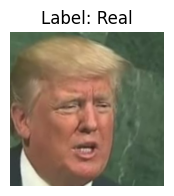

Image file name: valid_real_0519374.png
Image Shape: (256, 256)


In [41]:
# Load the first image from the balanced dataset
image_path, label = train_balanced_dataset[0]
image_path, label = test_balanced_dataset[0]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(2, 2))  # Adjust the figsize to make the image smaller
plt.imshow(image)
plt.title(f"Label: {'Fake' if label == 0 else 'Real'}")
plt.xlabel(os.path.basename(image_path))  # Display the image name
plt.axis('off')  # Hide the axis
plt.show()

# Display the image file name after the image
print(f"Image file name: {os.path.basename(image_path)}")
print(f"Image Shape: {image.size}")

5.1 Plot more Images

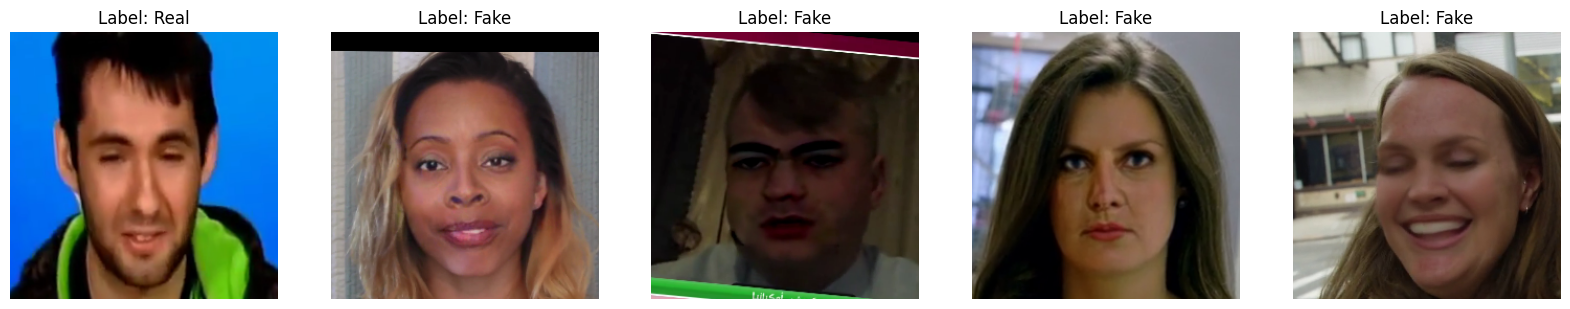

Image file name: train_real_0520355.png
Image file name: train_fake_0058383.png
Image file name: train_fake_0069311.png
Image file name: train_fake_0013708.png
Image file name: train_fake_0071346.png


In [42]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_balanced_dataset)), 5)
balanced_dataset5_1 = train_balanced_dataset
#selected_indices = random.sample(range(len(test_balanced_dataset)), 5)
# balanced_dataset5_1 = test_balanced_dataset


# Display 5 images in a row
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset5_1[idx]
    image = Image.open(image_path)
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Fake' if label == 0 else 'Real'}")
    axes[i].set_xlabel(os.path.basename(image_path))  # Display the image name
    axes[i].axis('off')  # Hide the axis

plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset5_1[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    

6. Getting the datasets ( Setup training data)

6.1 Finding out mean and std to use in the transform

6.2 Creating the datasets

In [43]:
# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()  # Call the parent class's init method
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Define transforms
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Define the classes
classes = ['fake', 'real']

#Create the dataset
train_data = ImageDataset(train_balanced_dataset, 
                          transform=transform)

#Create the dataset
test_data = ImageDataset(test_balanced_dataset, 
                        transform=transform)

# Example: Print the class name of a label
for image, label in test_data:
    class_name = classes[label]
    #print(f"Image label: {label}, Class name: {class_name}")
    #break  # Just print the first one for demonstration


7. Visualize train_data and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.490453..1.6158917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5730798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.2648343].


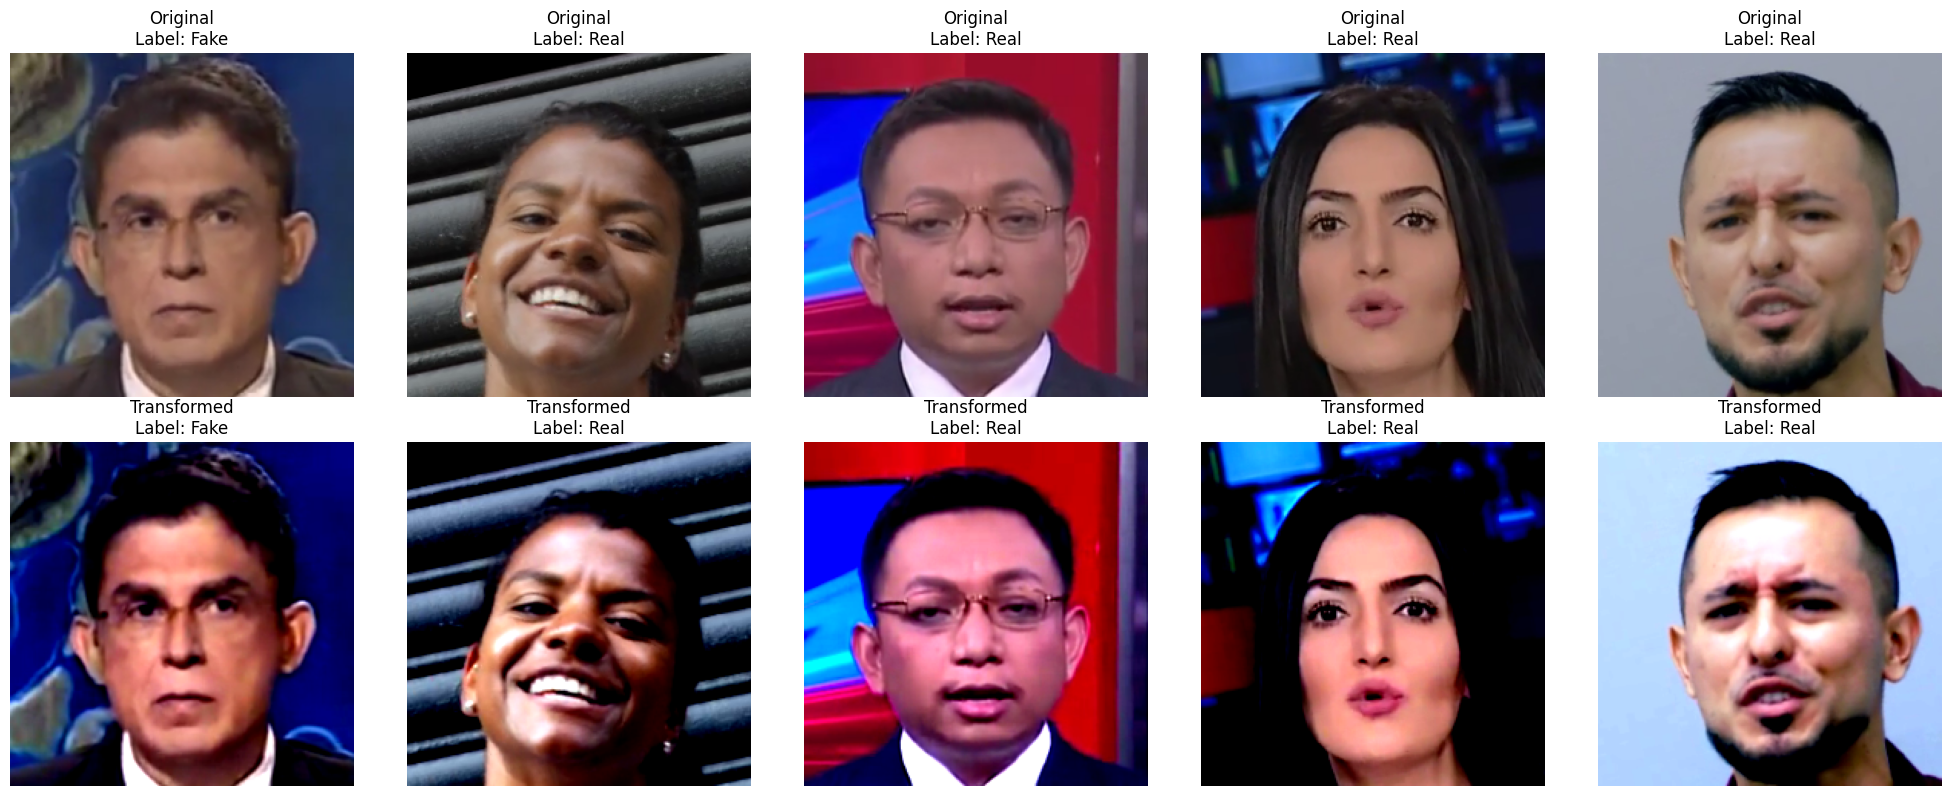

In [44]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.random.manual_seed(42)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_balanced_dataset)), 5)

# Display 5 images before and after transform
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = train_balanced_dataset[idx]
    image = Image.open(image_path).convert("RGB")
    
    # Display original image
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Original\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[0, i].axis('off')  # Hide the axis

    # Apply transform and display transformed image
    transformed_image = transform(image)
    axes[1, i].imshow(transformed_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
    axes[1, i].set_title(f"Transformed\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[1, i].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [45]:
print(len(train_data)) 
print(len(test_data))

image, label = train_data[700] # Label is 1
#image, label = train_data[1600] # Label is 0
print(image.shape, label)

# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {[label]}")

80000
3072
torch.Size([3, 224, 224]) 0
Image shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image label: [0]


7.1 Checking Labels of more data

In [46]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#dataset = train_data
dataset = test_data


# Select 50 random images
selected_indices = random.sample(range(len(dataset)), 10)

# Print the shape of images and labels of 50 random images
for idx in selected_indices:
    image, label = dataset[idx]
    image_path, _ = dataset.data[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}, Label: {label}")

Image file name: valid_fake_0337839.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_fake_0268756.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_fake_0050268.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_fake_0852912.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_real_0395285.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0530143.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_real_0768412.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0369189.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_real_0116879.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0054942.png
Image shape: torch.Size([3, 224, 224]), Label: 0


7.2 Visualize our data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.82].


Image shape: torch.Size([3, 224, 224])


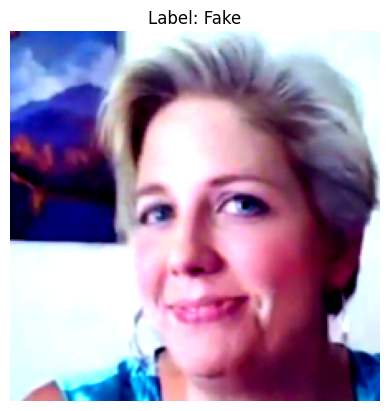

Image file name: valid_fake_0054942.png


In [47]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
# Unnormalize the image
# We have to use the relevant mean and std values for this
plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
plt.title(f"Label: {'Fake' if label == 0 else 'Real'}")
plt.axis('off')
plt.show()
image_path, _ = dataset.data[idx]
print(f"Image file name: {os.path.basename(image_path)}")

7.3 Visualize more data

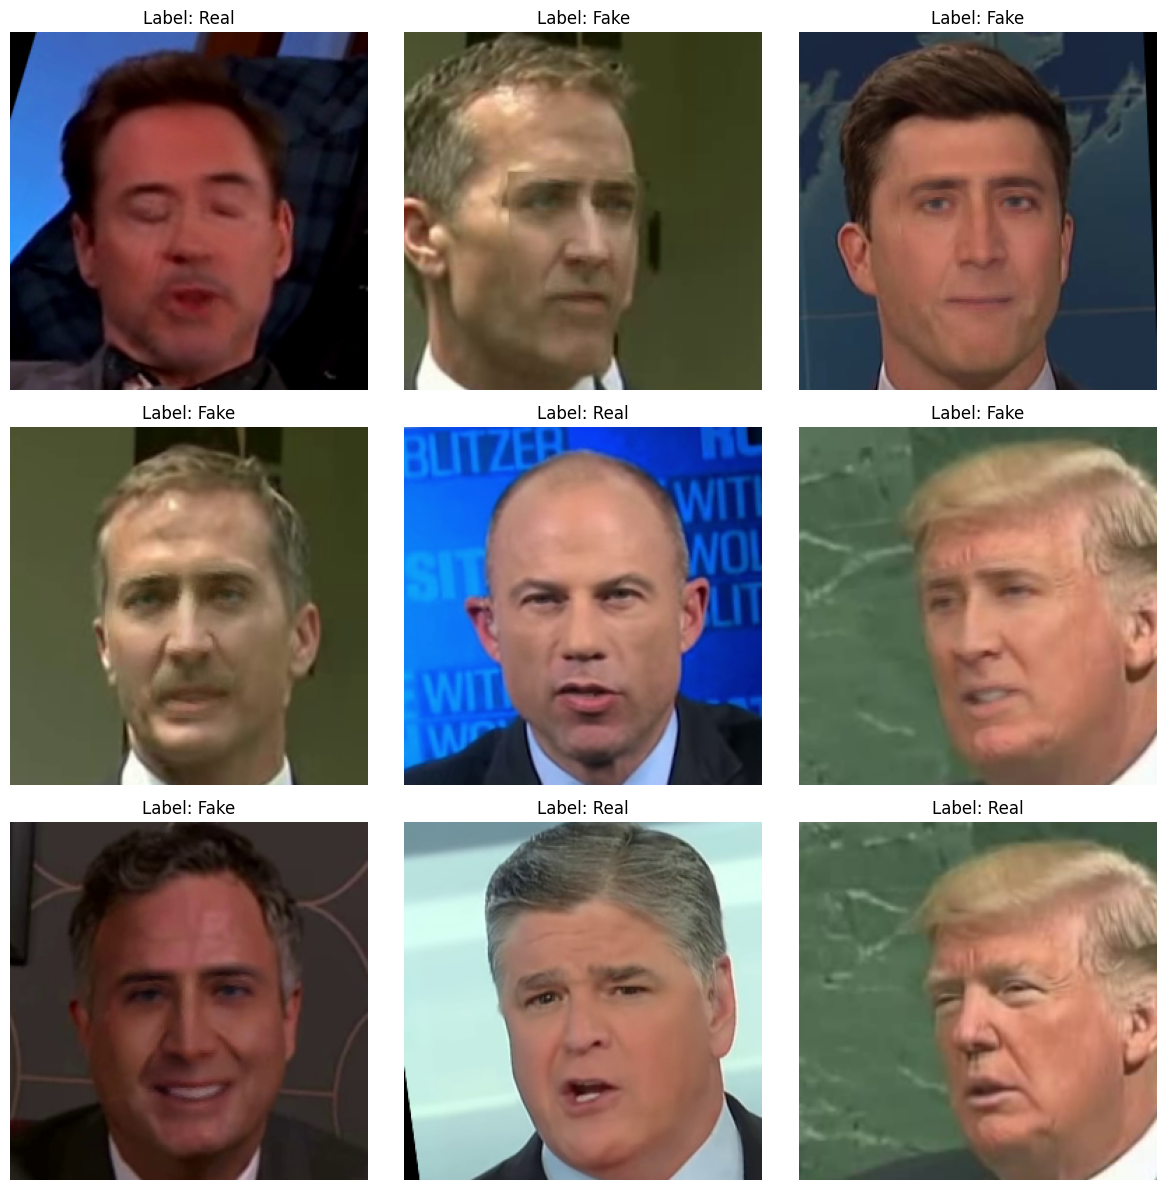

Image file name: valid_real_0957280.png
Image file name: valid_fake_0870315.png
Image file name: valid_fake_0262944.png
Image file name: valid_fake_0170279.png
Image file name: valid_real_0020516.png
Image file name: valid_fake_0570791.png
Image file name: valid_fake_0430112.png
Image file name: valid_real_0455716.png
Image file name: valid_real_0584748.png


In [48]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

balanced_dataset7_3 = train_balanced_dataset
balanced_dataset7_3 = test_balanced_dataset

# Randomly select 9 images from the balanced dataset
selected_indices = random.sample(range(len(balanced_dataset7_3)), 9)

# Display 9 images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset7_3[idx]
    image = Image.open(image_path)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Label: {'Fake' if label == 0 else 'Real'}")
    ax.set_xlabel(os.path.basename(image_path))  # Display the image name
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset7_3[idx]
    print(f"Image file name: {os.path.basename(image_path)}")

In [49]:
train_data

In [50]:
#Calculate the mean and std of the dataset

8. Prepare DataLoader

In [51]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=False)

test_dataloader = DataLoader(test_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# Example: Iterate through the DataLoader
for images, labels in test_dataloader:
    print(images.shape, labels.shape)
    break

print(images[0].shape)
train_dataloader, test_dataloader

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224])


(<torch.utils.data.dataloader.DataLoader at 0x1c3224e9130>,
 <torch.utils.data.dataloader.DataLoader at 0x1c323d96a80>)

8.1 Check what we have created

In [52]:
# Let's check out what what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(test_dataloader)}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001C3224E9130>, <torch.utils.data.dataloader.DataLoader object at 0x000001C323D96A80>)
Length of train_dataloader: 5000 batches of 16... = 80000
Length of test_dataloader: 192 batches of 16... = 3072


8.2 What's inside the dataloaders

In [53]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

9. Building a baseline Model

In [54]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 50176]) -> [color_channels, height*width]


9.1 Modelv0

In [55]:
#from torch import nn
#class DeepFakeDetectV0(nn.Module):
#  def __init__(self,
#               input_shape: int,
#               hidden_units: int,
#               output_shape: int):
#    super().__init__()
#    self.layer_stack = nn.Sequential(
#        nn.Flatten(),
#        nn.Linear(in_features=input_shape,
#                  out_features=hidden_units),
#        nn.Linear(in_features=hidden_units,
#                  out_features=output_shape)
#    )
#
#  def forward(self, x):
#    return self.layer_stack(x)

In [56]:
from torch import nn
# Load pre-trained EfficientNet model
class DeepFakeDetectV0(nn.Module):
    def __init__(self, output_shape: int):
        super(DeepFakeDetectV0, self).__init__()
        # Load pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Unfreeze more layers
        for param in self.efficientnet.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, output_shape)
        )
        
    def forward(self, x):
        return self.efficientnet(x)

In [57]:
len(classes)

2

9.2 Setup the model for the first time

In [58]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


torch.manual_seed(42)
model_0 = DeepFakeDetectV0(output_shape=1)
model_0.to(device)

# Check the device of the model
model_0_device = next(model_0.parameters()).device
print(f"Model is on device: {model_0_device}")
model_0

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is on device: cuda:0


DeepFakeDetectV0(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [59]:
# Setup model with input parameters
#model_0 = DeepFakeDetectV0(
#    input_shape=3*224*224, # this is 128*128 (height*width)
#    hidden_units=10, # how mnay units in the hidden layer
#    output_shape=1 # one for every class
#).to("cpu")

9.3 Send a random value through to check the output

In [60]:
# Test with random tensor (batch_size=32, channels=3, height=224, width=224)
test_input = torch.randn(32, 3, 224, 224).to(device)
output = model_0(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Sample predictions:\n{output[:5].cpu().detach().numpy()}")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 1])
Sample predictions:
[[-0.0065593 ]
 [-0.00191861]
 [-0.3246561 ]
 [-0.20881483]
 [-0.05703238]]


In [61]:
dummy_x = torch.rand([1, 3, 224, 224]).to(device)
model_0(dummy_x)


tensor([[-0.0314]], device='cuda:0', grad_fn=<AddmmBackward0>)

9.4 Check the State Dictionary of the model

In [62]:
model_0.state_dict()

OrderedDict([('efficientnet.features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [

10. Setup Loss, Optimizer and evaluation metrics

10.1 Setup Loss and Optimizer

In [63]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(),
                            #lr=0.01)
# Define the optimizer
optimizer = optim.Adam(model_0.parameters(), lr=0.01)

# Define the learning rate scheduler
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

10.2 Function to time our experiments

In [64]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


3.9700011257082224e-05

In [65]:
# Iterate through the test_dataloader and print the first 5 values
for i, (images, labels) in enumerate(test_dataloader):
    if i < 1:
        print(f"Batch {i+1}:")
        print(f"Images: {images}")
        print(f"Labels: {labels}")
    else:
        break

Batch 1:
Images: tensor([[[[-0.7822, -0.7822, -0.7822,  ..., -1.0219, -1.0219, -1.0219],
          [-0.7650, -0.7650, -0.7822,  ..., -1.0219, -1.0219, -1.0219],
          [-0.7822, -0.7822, -0.7822,  ..., -1.0219, -1.0219, -1.0219],
          ...,
          [-1.1932, -1.1932, -1.2103,  ..., -1.0048, -1.0390, -1.0733],
          [-1.1932, -1.1932, -1.2103,  ..., -1.0048, -1.0219, -1.0733],
          [-1.1760, -1.1760, -1.1932,  ..., -1.0048, -1.0219, -1.0390]],

         [[-0.1975, -0.1975, -0.1975,  ..., -0.4951, -0.4951, -0.4951],
          [-0.1800, -0.1800, -0.1975,  ..., -0.4951, -0.4951, -0.4951],
          [-0.1975, -0.1975, -0.1975,  ..., -0.4951, -0.4951, -0.4951],
          ...,
          [-0.9328, -0.9328, -0.9503,  ..., -0.4951, -0.5301, -0.5651],
          [-0.9328, -0.9328, -0.9503,  ..., -0.4951, -0.5126, -0.5651],
          [-0.9153, -0.9153, -0.9328,  ..., -0.4951, -0.5126, -0.5301]],

         [[-0.4624, -0.4624, -0.4624,  ..., -0.6541, -0.6541, -0.6541],
          [-0

In [66]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)  # Move tensors to the same device as the model
    # 1. Forward pass
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0468],
        [0.0186],
        [0.1924],
        [0.0880],
        [0.1747]], device='cuda:0')

In [67]:
y_test[:5]

tensor([0, 0, 1, 0, 0], device='cuda:0')

In [68]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5117],
        [0.5047],
        [0.5480],
        [0.5220],
        [0.5436]], device='cuda:0')

In [69]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# Convert the tensor to a list of labels
y_pred_labels = [classes[int(label)] for label in y_preds]

print(y_pred_labels)

['real', 'real', 'real', 'real', 'real']


In [70]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

11. Creating a Training loop and training the model

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 10

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### Training
  train_loss, train_acc = 0, 0
  batch_accuracy = 0

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(tqdm(train_dataloader)):
    # Put data to target device
    X, y = X.to(device), y.float().to(device)

    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X).squeeze()
    #print(y_pred.type)
    #print(y_pred[0])

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred.view(-1), y.float())
    train_loss += loss.item() # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.round(torch.sigmoid(y_pred))
    #print(y_pred_class)
    #print(y_pred_class.view(-1))
    batch_accuracy = (y_pred_class.view(-1) == y).sum().item() / len(y_pred_class)
    #print(f"Batch accuracy: {batch_accuracy}")

    # Accumulate the batch accuracy to the training accuracy
    train_acc += batch_accuracy
    #print(f"Cumulative training accuracy: {train_acc}")

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain loss: {train_loss:.4f}")
  print(f"Cumulative training accuracy: {train_acc}")

  ### Testing
  test_loss, correct_predictions, total_predictions = 0, 0, 0
  real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
  model_0.eval()
  with torch.inference_mode():
      for i, (X_test, y_test) in enumerate(test_dataloader):
          # Put data to target device
          X_test, y_test = X_test.to(device), y_test.float().to(device)

          # 1. Forward pass
          test_pred = model_0(X_test).squeeze()

          # 2. Calculate loss (accumulatively)
          test_loss += loss_fn(test_pred, y_test.float()).item()

          # 3. Calculate accuracy
          test_pred_class = torch.round(torch.sigmoid(test_pred))
          correct_predictions += (test_pred_class.view(-1) == y_test).sum().item()
          total_predictions += len(y_test)

          # Print image names and predictions
          for j in range(len(X_test)):
              image_index = i * test_dataloader.batch_size + j
              image_name = test_dataloader.dataset.data[image_index][0]
              true_label = test_dataloader.dataset.data[image_index][1]
              predicted_label = test_pred_class[j].item()
              #print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {predicted_label}")
              #print(f"Image: {image_name}, True Label: {classes[int(true_label)]}, Predicted Label: {classes[int(predicted_label)]}")

              if true_label == 0 and predicted_label == 0:
                  real_as_real += 1
              elif true_label == 0 and predicted_label == 1:
                  real_as_fake += 1
              elif true_label == 1 and predicted_label == 0:
                  fake_as_real += 1
              elif true_label == 1 and predicted_label == 1:
                  fake_as_fake += 1
              #print(real_as_real, real_as_fake, fake_as_real, fake_as_fake)

      # Calculate the test loss average per batch
      test_loss /= len(test_dataloader)

      # Calculate the test accuracy
      #test_acc = correct_predictions / total_predictions
      test_acc = (real_as_real + fake_as_fake) / (real_as_real + real_as_fake + fake_as_real + fake_as_fake)
      print(f"Real images identified as real: {real_as_real}")
      print(f"Real images identified as fake: {real_as_fake}")
      print(f"Fake images identified as real: {fake_as_real}")
      print(f"Fake images identified as fake: {fake_as_fake}")
      print(f"\nReal images Total: {real_as_real + real_as_fake} | Fake images Total: {fake_as_real + fake_as_fake}")
      print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"deepfake_detect_model_{timestamp}.pth"
  torch.save(model_0.state_dict(), model_save_path)
  print(f"Model saved to {model_save_path}")

  # Print out what's happening
  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.4f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.4f}%")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/5000 [00:00<?, ?it/s]

Looked at 0/80000 samples.
Looked at 6400/80000 samples.
Looked at 12800/80000 samples.
Looked at 19200/80000 samples.
Looked at 25600/80000 samples.
Looked at 32000/80000 samples.
Looked at 38400/80000 samples.
Looked at 44800/80000 samples.
Looked at 51200/80000 samples.
Looked at 57600/80000 samples.
Looked at 64000/80000 samples.
Looked at 70400/80000 samples.
Looked at 76800/80000 samples.

Train loss: 0.2550
Cumulative training accuracy: 0.89295
Real images identified as real: 1130
Real images identified as fake: 394
Fake images identified as real: 286
Fake images identified as fake: 1262

Real images Total: 1524 | Fake images Total: 1548

Test loss: 0.4713, Test acc: 0.7786
Model saved to deepfake_detect_model_20250111_150451.pth
Train loss: 0.2550 | Train acc: 89.2950% | Test loss: 0.4713 | Test acc: 77.8646%
Epoch: 1
------


  0%|          | 0/5000 [00:00<?, ?it/s]

Looked at 0/80000 samples.
Looked at 6400/80000 samples.
Looked at 12800/80000 samples.
Looked at 19200/80000 samples.


In [ ]:
#from datetime import datetime
#model_save_path = f"deepfake_detect_model_20250110_201404.pth"

# Load the trained model
#loaded_model = DeepFakeDetectV0(output_shape=1)
#loaded_model.load_state_dict(torch.load(model_save_path))
#loaded_model.to(device)
#print("Model loaded successfully")



In [73]:
from datetime import datetime
model_save_path = f"deepfake_detect_model_20250111_150451.pth"

# Load the trained model
loaded_model = DeepFakeDetectV0(output_shape=1)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
print("Model loaded successfully")

model_0 = loaded_model

Model loaded successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14072\1542578965.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


In [ ]:
### Testing
test_loss, correct_predictions, total_predictions = 0, 0, 0
real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
model_0.eval()
with torch.inference_mode():
    for i, (X_test, y_test) in enumerate(test_dataloader):
        # Put data to target device
        X_test, y_test = X_test.to(device), y_test.float().to(device)

        # 1. Forward pass
        test_pred = model_0(X_test).squeeze()

        # 2. Calculate loss (accumulatively)
        test_loss += loss_fn(test_pred, y_test.float()).item()

        # 3. Calculate accuracy
        test_pred_class = torch.round(torch.sigmoid(test_pred))
        correct_predictions += (test_pred_class.view(-1) == y_test).sum().item()
        total_predictions += len(y_test)

        # Print image names and predictions
        for j in range(len(X_test)):
            image_index = i * test_dataloader.batch_size + j
            image_name = test_dataloader.dataset.data[image_index][0]
            true_label = test_dataloader.dataset.data[image_index][1]
            predicted_label = test_pred_class[j].item()
            #print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {predicted_label}")
            #print(f"Image: {image_name}, True Label: {classes[int(true_label)]}, Predicted Label: {classes[int(predicted_label)]}")

            if true_label == 1 and predicted_label == 1:
                real_as_real += 1
            elif true_label == 1 and predicted_label == 0:
                real_as_fake += 1
            elif true_label == 0 and predicted_label == 1:
                fake_as_real += 1
            elif true_label == 0 and predicted_label == 0:
                fake_as_fake += 1
            #print(real_as_real, real_as_fake, fake_as_real, fake_as_fake)

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test accuracy
    #test_acc = correct_predictions / total_predictions
    test_acc = (real_as_real + fake_as_fake) / (real_as_real + real_as_fake + fake_as_real + fake_as_fake)
    print(f"Real images identified as real: {real_as_real}")
    print(f"Real images identified as fake: {real_as_fake}")
    print(f"Fake images identified as real: {fake_as_real}")
    print(f"Fake images identified as fake: {fake_as_fake}")
    print(f"\nReal images Total: {real_as_real + real_as_fake} | Fake images Total: {fake_as_real + fake_as_fake}")
    print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Print out what's happening
print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc*100:.4f}%")


Real images identified as real: 1295
Real images identified as fake: 253
Fake images identified as real: 484
Fake images identified as fake: 1040

Real images Total: 1548 | Fake images Total: 1524

Test loss: 0.4887, Test acc: 0.7601
Test loss: 0.4887, Test acc: 0.7601


In [ ]:
model_0.state_dict()